# Models Creation

In [24]:
import cv2
import numpy as np
import os
import sys
import pandas as pd
from sklearn.model_selection import train_test_split

In [25]:
import tensorflow as tf

In [26]:
# Listar GPUs disponibles
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Asegúrate de que la GPU 1 existe
        print("GPUs disponibles:")
        for i, gpu in enumerate(gpus):
            print(f"GPU {i}: {gpu}")

        # Limitar visibilidad a solo la GPU 1
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')

        # Establecer límite de memoria a 40 GB
        tf.config.experimental.set_virtual_device_configuration(
            gpus[1],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=40960)]
        )

        print("Configuración de GPU establecida correctamente.")
    except RuntimeError as e:
        print("Error al configurar la GPU:", e)
else:
    print("No se encontraron GPUs disponibles.")

GPUs disponibles:
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU 1: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
Configuración de GPU establecida correctamente.


In [27]:
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [28]:
# Poner todas las seed en 42
import random
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [29]:
# Agrega el path al directorio raíz del proyecto
sys.path.append(os.path.abspath(".."))
from models.i3d import InceptionI3d, Logits

In [30]:
train_df = pd.read_csv("../data/ml/train.csv")
valid_df = pd.read_csv("../data/ml/valid.csv")
test_df = pd.read_csv("../data/ml/test.csv")


In [31]:
"""data = pd.read_csv("../data/ml/test.csv")
# Dividir el dataset en train (80%), valid (10%), test (10%)
train_df, test_valid_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data['is_crime'])
valid_df, test_df = train_test_split(test_valid_df, test_size=0.5, random_state=42)"""

'data = pd.read_csv("../data/ml/test.csv")\n# Dividir el dataset en train (80%), valid (10%), test (10%)\ntrain_df, test_valid_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data[\'is_crime\'])\nvalid_df, test_df = train_test_split(test_valid_df, test_size=0.5, random_state=42)'

## Data Loader

In [32]:
from tensorflow.keras.utils import to_categorical
class VideoDataModule:
    def __init__(self, train_df, val_df, test_df, batch_size=32, frame_size=(224, 224), num_frames=32):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.frame_size = frame_size
        self.num_frames = num_frames
        tf.random.set_seed(42)  # Establecer la semilla

    def _load_video_frames(self, video_path, start_frame, end_frame, training=False):
        cap = cv2.VideoCapture(video_path)
        
        if not cap.isOpened():
            print(f"Error: No se pudo abrir el video {video_path}")
            return None
        
        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        start_frame = int(start_frame) if not np.isnan(start_frame) else 0
        end_frame = int(end_frame) if not np.isnan(end_frame) else total_frames
        
        # Chequear si el video tiene suficientes frames
        if end_frame - start_frame < self.num_frames:
            print(f"Advertencia: {video_path} tiene menos frames que los requeridos. Usando todo el video.")
        
        # Temporal offset aleatorio
        if training:
            # Ajustar máximo punto de inicio si hay menos frames disponibles que num_frames
            max_start = max(start_frame, end_frame - self.num_frames * max(1, (end_frame - start_frame) // self.num_frames))
            clip_start = np.random.randint(start_frame, max_start + 1)
        else:
            clip_start = start_frame
        
        cap.set(cv2.CAP_PROP_POS_FRAMES, clip_start)

        step = max(1, (end_frame - start_frame) // self.num_frames)

        for _ in range(self.num_frames):
            ret, frame = cap.read()
            if not ret:
                break
            
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = tf.convert_to_tensor(frame, dtype=tf.float32)

            if training:
                # Padding + random crop
                frame = tf.image.resize_with_crop_or_pad(frame, 240, 240)
                frame = tf.image.random_crop(frame, size=[*self.frame_size, 3])
                
                # Augmentaciones base
                frame = tf.image.random_flip_left_right(frame, seed=42)
                frame = tf.image.random_brightness(frame, max_delta=0.2, seed=42)
                frame = tf.image.random_contrast(frame, lower=0.8, upper=1.2, seed=42)
                frame = tf.image.random_hue(frame, max_delta=0.05, seed=42)

                # Posibilidad de añadir ruido o blur
                if np.random.rand() < 0.2:
                    noise = tf.random.normal(shape=tf.shape(frame), mean=0.0, stddev=5.0)
                    frame = tf.clip_by_value(frame + noise, 0.0, 255.0)

                if np.random.rand() < 0.2:
                    # Blur usando OpenCV
                    frame = tf.cast(frame, tf.uint8).numpy()
                    frame = cv2.GaussianBlur(frame, (5, 5), 0)
                    frame = tf.convert_to_tensor(frame, dtype=tf.float32)

            else:
                # Normal resize para validación/test
                frame = tf.image.resize(frame, self.frame_size)

            # Normalización final
            frame = frame / 255.0
            frames.append(frame.numpy())

            for _ in range(step - 1):  # Saltar frames para ajustarse al total
                cap.read()

        cap.release()

        # Si faltan frames, completamos con ceros
        while len(frames) < self.num_frames:
            frames.append(np.zeros((*self.frame_size, 3)))

        return np.array(frames, dtype=np.float32)


    def _dataframe_to_tf_dataset(self, df, shuffle=True, training=False):
        file_paths = df["Path"].values
        start_frames = df["PCB"].values
        end_frames = df["End_Frame"].values
        labels = df["is_crime"].values.astype(np.float32)  # Convertir a float32

        def generator():
            for i in range(len(file_paths)):
                video_tensor = self._load_video_frames(file_paths[i], start_frames[i], end_frames[i], training)
                # Cambiamos la forma de la etiqueta para que sea (1,) en lugar de un escalar
                yield video_tensor, np.array([labels[i]], dtype=np.float32)

        dataset = tf.data.Dataset.from_generator(
            generator,
            output_signature=(
                tf.TensorSpec(shape=(self.num_frames, *self.frame_size, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(1,), dtype=tf.float32),  # Cambiado a (1,) en lugar de (2,)
            ),
        )

        if shuffle:
            dataset = dataset.shuffle(
                buffer_size=min(max(1000, len(df)//10), len(df)),  
                seed=42,  
                reshuffle_each_iteration=True  
            )

        dataset = dataset.batch(self.batch_size).prefetch(tf.data.AUTOTUNE)
        return dataset

    def train_dataset(self):
        return self._dataframe_to_tf_dataset(self.train_df, shuffle=True, training=True)

    def val_dataset(self):
        return self._dataframe_to_tf_dataset(self.val_df, shuffle=False, training=False)

    def test_dataset(self):
        return self._dataframe_to_tf_dataset(self.test_df, shuffle=False, training=False)

## Train with checkpoints

In [33]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
def train_with_checkpoints(model, train_dataset, val_dataset, epochs, checkpoint_dir, one_cycle_scheduler):
    os.makedirs(checkpoint_dir, exist_ok=True)

    last_epoch_file = os.path.join(checkpoint_dir, "last_epoch.npy")
    history_file = os.path.join(checkpoint_dir, "history.npy")

    # Callback para guardar TODAS las épocas
    full_history_callback = ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, "epoch_{epoch:02d}"),
        save_freq='epoch',
        save_weights_only=True
    )

    # Callback para guardar solo el MEJOR modelo
    best_model_callback = ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, "best_model"),
        monitor="val_loss",
        mode="min",
        save_best_only=True,
        save_weights_only=True
    )

    # Intentar cargar la última época guardada
    if os.path.exists(last_epoch_file):
        initial_epoch = int(np.load(last_epoch_file))
        model.load_weights(os.path.join(checkpoint_dir, "best_model"))
        print(f"Resuming training from epoch {initial_epoch}")
    else:
        initial_epoch = 0
        print("Starting training from scratch.")

    # Callback para detener el entrenamiento si no hay mejora
    early_stop_callback = EarlyStopping(
        monitor="val_loss", 
        patience=20, 
        mode="min", 
        restore_best_weights=True
    )

    # Callback para guardar la época actual
    class EpochSaver(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            np.save(last_epoch_file, epoch + 1)

    # Callback para guardar historial después de cada época
    class HistorySaver(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            if logs is not None:
                history_full['loss'].append(logs.get('loss', None))
                history_full['val_loss'].append(logs.get('val_loss', None))
                np.save(history_file, history_full)

    epoch_saver_callback = EpochSaver()
    history_saver_callback = HistorySaver()
    lr_scheduler_callback = LearningRateScheduler(one_cycle_scheduler)
    # Cargar historial previo si existe
    if os.path.exists(history_file):
        history_full = np.load(history_file, allow_pickle=True).item()
    else:
        history_full = {'loss': [], 'val_loss': []}

    # Verificar si el entrenamiento ya ha terminado
    if initial_epoch >= epochs:
        print("Training already completed. No new epochs to run.")
        return None, history_full

    # Iniciar entrenamiento
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        initial_epoch=initial_epoch,
        callbacks=[ 
            best_model_callback, # Añadir early_stop_callback si es que no uso one cycle
            full_history_callback, 
            epoch_saver_callback, 
            history_saver_callback, 
            lr_scheduler_callback
        ],
        verbose=1
    )

    return history, history_full

## Max and Min Learning rate Finder

In [34]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Tuple

class LRFinder(tf.keras.callbacks.Callback):
    def __init__(self, min_lr: float = 1e-6, max_lr: float = 1, steps: int = 100, smoothing: float = 0.05):
        super().__init__()
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_steps = steps
        self.smoothing = smoothing  # Para suavizado exponencial de la pérdida
        self.lrs = []
        self.losses = []
        self.smoothed_losses = []
        self.best_loss = float("inf")
        self._step = 0
        self._avg_loss = 0

    def on_train_begin(self, logs=None):
        self._step = 0
        self.lr_mult = (self.max_lr / self.min_lr) ** (1 / self.total_steps)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.min_lr)
        self.lrs.clear()
        self.losses.clear()
        self.smoothed_losses.clear()
        self.best_loss = float("inf")
        self._avg_loss = 0

    def on_batch_end(self, batch, logs=None):
        self._step += 1
        lr = tf.keras.backend.get_value(self.model.optimizer.lr)
        loss = logs["loss"]
        
        # Suavizado exponencial de la pérdida
        if self._step == 1:
            self._avg_loss = loss
        else:
            self._avg_loss = self.smoothing * loss + (1 - self.smoothing) * self._avg_loss
        
        self.lrs.append(lr)
        self.losses.append(loss)
        self.smoothed_losses.append(self._avg_loss)

        # Actualizar mejor pérdida
        if self._avg_loss < self.best_loss:
            self.best_loss = self._avg_loss

        # Condición de parada
        if self._step > self.total_steps or tf.math.is_nan(loss): # or loss > self.best_loss * 10:
            self.model.stop_training = True
            return

        # Actualizar LR para el siguiente batch
        lr *= self.lr_mult
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)

    def plot_loss(self, skip_start: int = 10, skip_end: int = 5, log_scale: bool = True):
        """Grafica la pérdida vs learning rate."""
        lrs = self.lrs[skip_start:-skip_end or None]
        losses = self.smoothed_losses[skip_start:-skip_end or None]
        
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(lrs, losses)
        
        if log_scale:
            ax.set_xscale('log')
        
        ax.set_xlabel('Learning Rate')
        ax.set_ylabel('Loss')
        ax.set_title('Learning Rate Finder')
        ax.grid(True, which='both', linestyle='--', alpha=0.6)
        return fig, ax

    

## I3D Model

In [35]:
epochs = 100  # Número de épocas para el entrenamiento

In [36]:
# Paso 1: Cargar el modelo preentrenado con 400 clases
pretrained_i3d = InceptionI3d(num_classes=400, is_training=False, final_endpoint='Logits')

# Paso 2: Ejecutar un forward pass para construir el modelo y variables
dummy_input = tf.random.normal([1, 64, 224, 224, 3])
pretrained_i3d(dummy_input)

# Paso 3: Cargar el checkpoint preentrenado (ajusta la ruta si es necesario)
checkpoint_path = '../models/checkpoints/rgb_imagenet/model.ckpt'
ckpt = tf.train.Checkpoint(model=pretrained_i3d)
ckpt.restore(checkpoint_path).expect_partial()  # Solo cargamos las capas comunes, no Logits final

# Paso 4: Reemplazar la capa de logits con una nueva para clasificación binaria
pretrained_i3d.Logits = Logits(num_classes=1, is_training=True, dropout_keep_prob=0.5)

In [37]:
# Clase adaptadora para usar InceptionI3D como modelo de Keras
class KerasI3D(tf.keras.Model):
    def __init__(self, base_model):
        super(KerasI3D, self).__init__()
        self.i3d = base_model
        # Añadir una capa de activación Sigmoid después del modelo base
        self.sigmoid = tf.keras.layers.Activation('sigmoid')

    def call(self, inputs, training=False):
        logits, _ = self.i3d(inputs)  # salida de logits sin activación
        probabilities = self.sigmoid(logits)  # aplicar sigmoide a los logits
        return probabilities

### Modelo

In [38]:
initial_learning_rate = 1e-8

In [39]:
from tensorflow.keras.metrics import AUC

# Crear el DataModule
data_module = VideoDataModule(train_df, valid_df, test_df, batch_size=8)
# Obtener los datasets
train_dataset = data_module.train_dataset()
val_dataset = data_module.val_dataset()
test_dataset = data_module.test_dataset()
model_1 = KerasI3D(pretrained_i3d)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=initial_learning_rate,
)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
model_1.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy", AUC(name="auc")])

In [40]:
# Instanciar el LRFinder
lr_finder = LRFinder(min_lr=initial_learning_rate, max_lr=7e-2, steps=65, smoothing=0.1)

model_1.fit(
    train_dataset.take(200),  
    epochs=1,
    callbacks=[lr_finder]
)

2025-04-16 02:58:38.921787: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 02:58:48.554370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 02:58:58.396557: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 101 of 516
2025-04-16 02:59:08.608946: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-16 02:59:18.482440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 159 of 516
2025-04-16 02:59:28.713176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-16 02:59:39.034499: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 02:59:48.573709: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 246 of 516
2025-04-16 02:59:58.516179: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

      6/Unknown - 177s 263ms/step - loss: 0.6925 - accuracy: 0.5833 - auc: 0.5260WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1143s vs `on_train_batch_end` time: 0.1472s). Check your callbacks.
65/65 [==============================] - 192s 255ms/step - loss: 119.1605 - accuracy: 0.5891 - auc: 0.5906


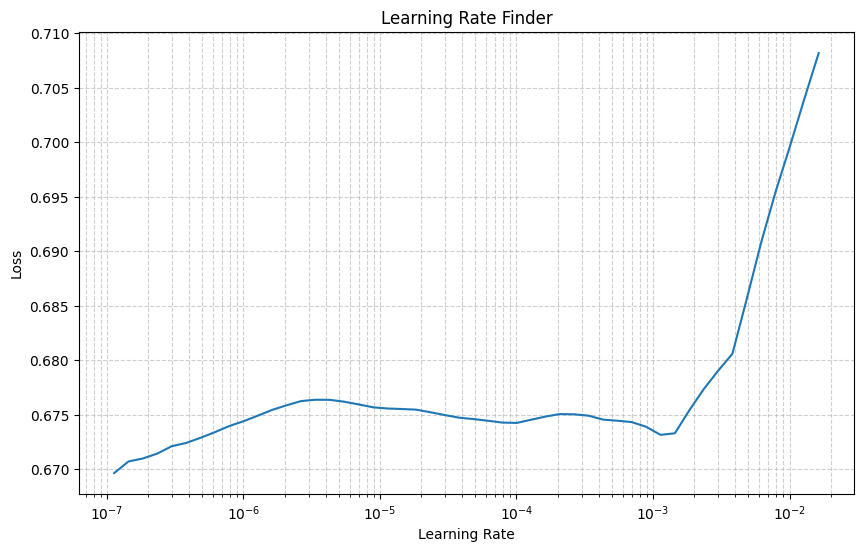

In [41]:
# Visualización
fix, ax = lr_finder.plot_loss()
plt.show()

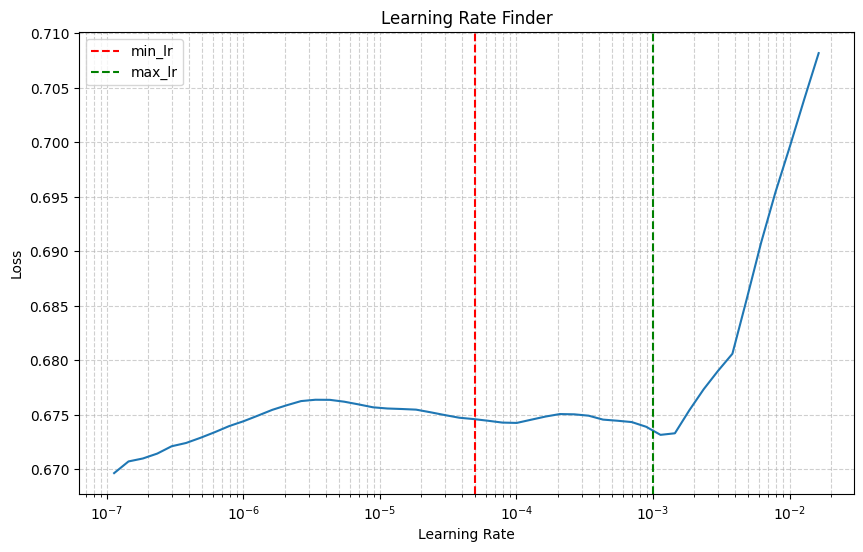

In [42]:
# Incluye el min_lir y el max_lr
fix, ax = lr_finder.plot_loss()
min_lr = 5e-5
max_lr = 1e-3
ax.axvline(x=min_lr, color='r', linestyle='--', label='min_lr')
ax.axvline(x=max_lr, color='g', linestyle='--', label='max_lr')
ax.legend()
plt.show()

### One Cycle Policy

In [43]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [44]:
def one_cycle_scheduler(epoch, lr):
    total_epochs = epochs
    warmup_epochs = total_epochs // 4

    if epoch < warmup_epochs:  # Warmup
        return initial_learning_rate + (max_lr - initial_learning_rate) * (epoch / warmup_epochs)
    
    elif epoch < total_epochs - 5:  # Cosine annealing phase
        return min_lr + (max_lr - min_lr) * 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs - 5)))

    else:  # Final annealing phase
        return min_lr

### Training

In [45]:
history, history_full = train_with_checkpoints(
    model_1,
    train_dataset,
    val_dataset,
    epochs=epochs,
    checkpoint_dir="checkpoints/i3d_model",
    one_cycle_scheduler=one_cycle_scheduler
)

Starting training from scratch.
Epoch 1/100


2025-04-16 03:01:47.143310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 03:01:56.830075: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 03:02:07.006266: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 03:02:17.124248: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 03:02:26.883427: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 03:02:37.373495: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 03:02:46.824328: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 03:02:56.877453: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-16 03:03:06.990166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

      6/Unknown - 172s 236ms/step - loss: 6458.9917 - accuracy: 0.5833 - auc: 0.5000WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1076s vs `on_train_batch_end` time: 0.1272s). Check your callbacks.
65/65 [==============================] - 208s 575ms/step - loss: 7713.6250 - accuracy: 0.5000 - auc: 0.5000 - val_loss: 7969.0869 - val_accuracy: 0.5077 - val_auc: 0.5000
Epoch 2/100


2025-04-16 03:05:18.203303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 03:05:27.973801: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 03:05:37.928968: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 03:05:48.022636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 03:05:57.838511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 03:06:08.325585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 03:06:17.920044: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 03:06:27.922082: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-16 03:06:37.984557: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 205s 540ms/step - loss: 3609.4463 - accuracy: 0.5000 - auc: 0.5000 - val_loss: 1321.2137 - val_accuracy: 0.5077 - val_auc: 0.5000
Epoch 3/100


2025-04-16 03:08:46.390292: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 03:08:56.263955: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 72 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 03:09:06.124428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 104 of 516
2025-04-16 03:09:16.219800: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 03:09:26.147327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 162 of 516
2025-04-16 03:09:36.301427: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 192 of 516
2025-04-16 03:09:46.708842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 221 of 516
2025-04-16 03:09:56.245834: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 250 of 516
2025-04-16 03:10:06.258525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 203s 535ms/step - loss: 300.9350 - accuracy: 0.4903 - auc: 0.4863 - val_loss: 12.2900 - val_accuracy: 0.4615 - val_auc: 0.4910
Epoch 4/100


2025-04-16 03:12:12.530948: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 03:12:22.335066: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 72 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 03:12:32.279111: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 104 of 516
2025-04-16 03:12:42.362595: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 03:12:52.360772: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 162 of 516
2025-04-16 03:13:02.559329: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 192 of 516
2025-04-16 03:13:12.330993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 03:13:22.626767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 250 of 516
2025-04-16 03:13:32.331697: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 538ms/step - loss: 10.1082 - accuracy: 0.4864 - auc: 0.4852 - val_loss: 9.4436 - val_accuracy: 0.4923 - val_auc: 0.4943
Epoch 5/100


2025-04-16 03:15:40.132673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 03:15:50.197242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 72 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 03:16:00.008085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-16 03:16:10.361178: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 03:16:20.188802: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 03:16:30.217504: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 03:16:40.423847: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 03:16:49.958787: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 248 of 516
2025-04-16 03:16:59.936464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 533ms/step - loss: 8.7391 - accuracy: 0.5136 - auc: 0.5207 - val_loss: 8.4266 - val_accuracy: 0.5077 - val_auc: 0.4995
Epoch 6/100


2025-04-16 03:19:07.715997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 03:19:17.638435: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 72 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 03:19:27.563016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 104 of 516
2025-04-16 03:19:37.595405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 03:19:47.511460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 162 of 516
2025-04-16 03:19:57.620536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 192 of 516
2025-04-16 03:20:08.048940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 221 of 516
2025-04-16 03:20:17.585229: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 250 of 516
2025-04-16 03:20:27.660117: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 203s 534ms/step - loss: 7.5681 - accuracy: 0.4884 - auc: 0.4945 - val_loss: 5.3417 - val_accuracy: 0.5231 - val_auc: 0.5166
Epoch 7/100


2025-04-16 03:22:34.371377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 03:22:44.314951: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 72 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 03:22:54.028237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-16 03:23:04.316461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 03:23:14.044087: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 03:23:24.312966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 192 of 516
2025-04-16 03:23:34.711684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 221 of 516
2025-04-16 03:23:44.283766: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 250 of 516
2025-04-16 03:23:54.030039: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 203s 532ms/step - loss: 6.1149 - accuracy: 0.4826 - auc: 0.4643 - val_loss: 7.5631 - val_accuracy: 0.5077 - val_auc: 0.5388
Epoch 8/100


2025-04-16 03:25:59.790160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 03:26:09.576367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 03:26:19.609074: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 03:26:29.688544: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 03:26:39.553186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 03:26:50.057435: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 03:26:59.641551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 03:27:09.588600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-16 03:27:19.665276: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 533ms/step - loss: 3.3199 - accuracy: 0.5271 - auc: 0.5332 - val_loss: 2.3881 - val_accuracy: 0.4462 - val_auc: 0.4621
Epoch 9/100


2025-04-16 03:29:27.534746: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 03:29:37.396589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 72 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 03:29:47.355556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 104 of 516
2025-04-16 03:29:57.391113: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 03:30:07.289062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 162 of 516
2025-04-16 03:30:17.437952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 192 of 516
2025-04-16 03:30:27.840267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 221 of 516
2025-04-16 03:30:37.382782: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 250 of 516
2025-04-16 03:30:47.343944: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 203s 534ms/step - loss: 1.5022 - accuracy: 0.5078 - auc: 0.5074 - val_loss: 0.8802 - val_accuracy: 0.6154 - val_auc: 0.6207
Epoch 10/100


2025-04-16 03:32:53.582878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 03:33:03.304009: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 03:33:13.389593: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-16 03:33:23.664146: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 03:33:33.413170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 03:33:43.320753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 03:33:53.471154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 03:34:03.841335: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 250 of 516
2025-04-16 03:34:13.469850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 203s 535ms/step - loss: 0.8406 - accuracy: 0.5039 - auc: 0.5098 - val_loss: 0.7546 - val_accuracy: 0.4308 - val_auc: 0.4366
Epoch 11/100


2025-04-16 03:36:20.173509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 03:36:29.943576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 72 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 03:36:39.742288: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-16 03:36:50.051758: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 03:36:59.808117: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 03:37:09.767844: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 03:37:19.806945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 03:37:30.180269: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 250 of 516
2025-04-16 03:37:39.866899: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 533ms/step - loss: 0.7348 - accuracy: 0.5116 - auc: 0.4933 - val_loss: 0.7269 - val_accuracy: 0.4923 - val_auc: 0.4744
Epoch 12/100


2025-04-16 03:39:47.431524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 03:39:57.140866: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 03:40:07.119619: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 03:40:17.227952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 03:40:27.094765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 03:40:37.605538: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 03:40:47.218003: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 03:40:57.264622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-16 03:41:07.451240: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 205s 533ms/step - loss: 0.7127 - accuracy: 0.5213 - auc: 0.5204 - val_loss: 0.6708 - val_accuracy: 0.6308 - val_auc: 0.6444
Epoch 13/100


2025-04-16 03:43:16.146143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 03:43:25.899018: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 03:43:35.829622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 03:43:46.029558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 03:43:55.994763: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 03:44:05.829571: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-16 03:44:16.112621: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 03:44:26.092700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-16 03:44:36.162447: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 205s 535ms/step - loss: 0.6829 - accuracy: 0.5543 - auc: 0.5850 - val_loss: 0.7065 - val_accuracy: 0.4154 - val_auc: 0.4867
Epoch 14/100


2025-04-16 03:46:42.741734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 03:46:52.461807: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 03:47:02.548777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-16 03:47:12.823081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 03:47:22.615451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 03:47:32.761098: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 192 of 516
2025-04-16 03:47:42.498635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 03:47:52.853627: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 250 of 516
2025-04-16 03:48:02.455354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 203s 535ms/step - loss: 0.7118 - accuracy: 0.4922 - auc: 0.4699 - val_loss: 0.6866 - val_accuracy: 0.5538 - val_auc: 0.5587
Epoch 15/100


2025-04-16 03:50:08.116405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 03:50:17.959654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 72 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 03:50:27.879135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 104 of 516
2025-04-16 03:50:38.099759: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 03:50:48.005852: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 03:50:58.074867: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 03:51:08.371077: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 03:51:17.928439: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 249 of 516
2025-04-16 03:51:27.959543: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 533ms/step - loss: 0.7034 - accuracy: 0.4845 - auc: 0.4953 - val_loss: 0.7044 - val_accuracy: 0.5077 - val_auc: 0.4602
Epoch 16/100


2025-04-16 03:53:33.837647: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 03:53:43.477299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 03:53:53.682826: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 104 of 516
2025-04-16 03:54:03.883451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 03:54:13.709179: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 03:54:23.600724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 03:54:33.758035: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 03:54:44.101325: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 250 of 516
2025-04-16 03:54:53.646064: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 535ms/step - loss: 0.7020 - accuracy: 0.4651 - auc: 0.4833 - val_loss: 0.6970 - val_accuracy: 0.5231 - val_auc: 0.4811
Epoch 17/100


2025-04-16 03:56:59.392682: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 03:57:09.363192: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 72 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 03:57:19.117484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-16 03:57:29.446173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 03:57:39.273005: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 03:57:49.253461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 03:57:59.438511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 03:58:09.099017: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 249 of 516
2025-04-16 03:58:19.144968: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 536ms/step - loss: 0.6924 - accuracy: 0.5446 - auc: 0.5325 - val_loss: 0.7030 - val_accuracy: 0.4923 - val_auc: 0.4493
Epoch 18/100


2025-04-16 04:00:24.687415: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 04:00:34.482222: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 04:00:44.521570: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 04:00:54.640349: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 04:01:04.549507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 04:01:14.415481: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-16 04:01:24.722528: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 04:01:34.709520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-16 04:01:44.816150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 205s 534ms/step - loss: 0.6950 - accuracy: 0.5329 - auc: 0.5339 - val_loss: 0.7138 - val_accuracy: 0.4923 - val_auc: 0.6004
Epoch 19/100


2025-04-16 04:03:51.671511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 04:04:01.290034: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 04:04:11.525014: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 04:04:21.327331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-16 04:04:31.220647: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 159 of 516
2025-04-16 04:04:41.439676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-16 04:04:51.763152: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 04:05:01.268244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 246 of 516
2025-04-16 04:05:11.737705: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 205s 537ms/step - loss: 0.6985 - accuracy: 0.5213 - auc: 0.5063 - val_loss: 0.6934 - val_accuracy: 0.5077 - val_auc: 0.5606
Epoch 20/100


2025-04-16 04:07:18.410986: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 04:07:28.097673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 04:07:38.336180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 04:07:48.081546: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-16 04:07:58.312442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 04:08:08.126943: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-16 04:08:18.475669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 04:08:28.086272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 246 of 516
2025-04-16 04:08:38.021980: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 206s 536ms/step - loss: 0.6974 - accuracy: 0.4961 - auc: 0.4772 - val_loss: 0.6970 - val_accuracy: 0.4615 - val_auc: 0.4176
Epoch 21/100


2025-04-16 04:10:45.645231: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 04:10:55.295280: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 04:11:05.293034: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-16 04:11:15.589251: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 04:11:25.416695: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 04:11:35.374266: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 04:11:45.521816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 04:11:55.827909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 250 of 516
2025-04-16 04:12:05.392674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 535ms/step - loss: 0.6939 - accuracy: 0.5019 - auc: 0.5052 - val_loss: 0.6962 - val_accuracy: 0.4923 - val_auc: 0.4219
Epoch 22/100


2025-04-16 04:14:11.065055: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 04:14:20.737884: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 04:14:30.806685: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-16 04:14:41.171158: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 04:14:50.915962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 04:15:00.895697: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 04:15:11.057570: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 04:15:20.878260: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 249 of 516
2025-04-16 04:15:30.770129: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 534ms/step - loss: 0.6970 - accuracy: 0.4748 - auc: 0.4573 - val_loss: 0.6914 - val_accuracy: 0.5077 - val_auc: 0.5876
Epoch 23/100


2025-04-16 04:17:36.217579: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 04:17:45.892727: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 04:17:55.935662: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-16 04:18:06.228823: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 04:18:16.081232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 04:18:26.168926: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 04:18:36.406397: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 04:18:45.977549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 248 of 516
2025-04-16 04:18:55.875767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 205s 534ms/step - loss: 0.6943 - accuracy: 0.5039 - auc: 0.5168 - val_loss: 0.6938 - val_accuracy: 0.4769 - val_auc: 0.4981
Epoch 24/100


2025-04-16 04:21:02.418285: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 04:21:12.061801: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 04:21:22.278171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 04:21:32.078624: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-16 04:21:42.385438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 04:21:52.190917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-16 04:22:02.570213: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 04:22:12.176736: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 246 of 516
2025-04-16 04:22:22.086600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 206s 532ms/step - loss: 0.6940 - accuracy: 0.4981 - auc: 0.4956 - val_loss: 0.6903 - val_accuracy: 0.6000 - val_auc: 0.6402
Epoch 25/100


2025-04-16 04:24:29.987718: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 04:24:39.727785: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 04:24:49.761059: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 04:24:59.967383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 04:25:09.877350: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 04:25:19.635522: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-16 04:25:29.872681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 04:25:39.660327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-16 04:25:49.784251: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 205s 533ms/step - loss: 0.6939 - accuracy: 0.5019 - auc: 0.4776 - val_loss: 0.6902 - val_accuracy: 0.5385 - val_auc: 0.5786
Epoch 26/100


2025-04-16 04:27:56.243126: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 04:28:05.974007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 04:28:15.972458: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-16 04:28:26.217346: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 04:28:36.097061: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 04:28:46.058043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 04:28:56.275159: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 04:29:05.947243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 249 of 516
2025-04-16 04:29:16.003100: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 535ms/step - loss: 0.6936 - accuracy: 0.5116 - auc: 0.5224 - val_loss: 0.6950 - val_accuracy: 0.4615 - val_auc: 0.4465
Epoch 27/100


2025-04-16 04:31:21.656067: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 04:31:31.424874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 04:31:41.412075: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 04:31:51.569485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 04:32:01.499657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 04:32:11.431531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-16 04:32:21.838282: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 04:32:31.430270: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 246 of 516
2025-04-16 04:32:41.382230: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 206s 534ms/step - loss: 0.6938 - accuracy: 0.5194 - auc: 0.4720 - val_loss: 0.6924 - val_accuracy: 0.5538 - val_auc: 0.5407
Epoch 28/100


2025-04-16 04:34:48.913678: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 04:34:58.639238: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 04:35:08.625785: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-16 04:35:18.906672: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 04:35:28.772338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 04:35:38.731885: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 04:35:48.963815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 04:35:59.304313: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 250 of 516
2025-04-16 04:36:08.845127: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 203s 535ms/step - loss: 0.6934 - accuracy: 0.4961 - auc: 0.4969 - val_loss: 0.6932 - val_accuracy: 0.5231 - val_auc: 0.4886
Epoch 29/100


2025-04-16 04:38:13.881654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 04:38:23.491395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 04:38:33.500240: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-16 04:38:43.769296: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 04:38:53.557660: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 04:39:03.447811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 04:39:13.570463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 04:39:23.926345: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 250 of 516
2025-04-16 04:39:33.596484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 203s 532ms/step - loss: 0.6931 - accuracy: 0.5097 - auc: 0.5012 - val_loss: 0.6929 - val_accuracy: 0.4615 - val_auc: 0.5308
Epoch 30/100


2025-04-16 04:41:38.413219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 04:41:48.079954: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 04:41:58.011672: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 101 of 516
2025-04-16 04:42:08.112417: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-16 04:42:18.320746: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 04:42:28.155398: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-16 04:42:38.519938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 04:42:48.129169: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 246 of 516
2025-04-16 04:42:58.100872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 207s 538ms/step - loss: 0.6927 - accuracy: 0.5116 - auc: 0.5112 - val_loss: 0.6947 - val_accuracy: 0.4462 - val_auc: 0.4545
Epoch 31/100


2025-04-16 04:45:06.370152: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 04:45:16.049969: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 04:45:26.112333: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-16 04:45:36.458747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 04:45:46.316988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 04:45:56.332922: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 04:46:06.507977: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 04:46:16.168503: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 249 of 516
2025-04-16 04:46:26.211294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 205s 534ms/step - loss: 0.6931 - accuracy: 0.5000 - auc: 0.5109 - val_loss: 0.6888 - val_accuracy: 0.6000 - val_auc: 0.6657
Epoch 32/100


2025-04-16 04:48:32.503788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 04:48:42.212382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 04:48:52.283617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-16 04:49:02.174659: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 04:49:12.463794: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 04:49:22.404490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 04:49:32.538029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 04:49:42.135530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 249 of 516
2025-04-16 04:49:52.338073: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 533ms/step - loss: 0.6945 - accuracy: 0.4884 - auc: 0.4627 - val_loss: 0.6918 - val_accuracy: 0.6154 - val_auc: 0.5417
Epoch 33/100


2025-04-16 04:51:57.663733: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 04:52:07.399360: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 04:52:17.245988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 04:52:27.329449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 04:52:37.650717: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 04:52:47.658660: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 04:52:57.806742: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 04:53:07.350438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 249 of 516
2025-04-16 04:53:17.225135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 534ms/step - loss: 0.6925 - accuracy: 0.5097 - auc: 0.5241 - val_loss: 0.6918 - val_accuracy: 0.5692 - val_auc: 0.5559
Epoch 34/100


2025-04-16 04:55:22.928810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 04:55:32.855834: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 72 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 04:55:42.815962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 104 of 516
2025-04-16 04:55:52.902267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 04:56:02.717965: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 04:56:12.757143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 04:56:22.939264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 04:56:33.310016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 250 of 516
2025-04-16 04:56:42.889979: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 531ms/step - loss: 0.6939 - accuracy: 0.5116 - auc: 0.4738 - val_loss: 0.6930 - val_accuracy: 0.4923 - val_auc: 0.5047
Epoch 35/100


2025-04-16 04:58:48.159798: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 04:58:57.958523: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 72 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 04:59:07.995734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 104 of 516
2025-04-16 04:59:17.950394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 04:59:27.889228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 04:59:38.401710: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 04:59:47.992919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 04:59:57.999756: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-16 05:00:07.934037: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 535ms/step - loss: 0.7589 - accuracy: 0.5291 - auc: 0.5071 - val_loss: 0.7083 - val_accuracy: 0.5077 - val_auc: 0.5682
Epoch 36/100


2025-04-16 05:02:13.579006: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 05:02:23.465042: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 72 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 05:02:33.297361: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 104 of 516
2025-04-16 05:02:43.328784: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 05:02:53.815057: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 163 of 516
2025-04-16 05:03:03.422261: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 192 of 516
2025-04-16 05:03:13.857329: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 221 of 516
2025-04-16 05:03:23.468800: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 250 of 516
2025-04-16 05:03:33.514820: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 203s 533ms/step - loss: 0.6996 - accuracy: 0.4942 - auc: 0.5037 - val_loss: 0.6909 - val_accuracy: 0.4923 - val_auc: 0.6127
Epoch 37/100


2025-04-16 05:05:38.181471: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 05:05:47.874518: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 05:05:57.925841: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-16 05:06:08.225500: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 05:06:18.003973: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 05:06:27.958010: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 05:06:38.128737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 05:06:48.489137: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 250 of 516
2025-04-16 05:06:57.968947: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 533ms/step - loss: 0.6940 - accuracy: 0.4961 - auc: 0.4602 - val_loss: 0.6929 - val_accuracy: 0.5077 - val_auc: 0.5019
Epoch 38/100


2025-04-16 05:09:03.296717: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 05:09:13.200967: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 72 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 05:09:23.006644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-16 05:09:33.295481: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 05:09:43.069954: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 05:09:53.037587: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 05:10:03.157871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 05:10:13.431634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 250 of 516
2025-04-16 05:10:23.049491: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 535ms/step - loss: 0.6936 - accuracy: 0.5000 - auc: 0.4982 - val_loss: 0.6928 - val_accuracy: 0.5077 - val_auc: 0.5975
Epoch 39/100


2025-04-16 05:12:28.377623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 05:12:38.042560: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 05:12:48.018148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 05:12:58.038681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 05:13:08.291275: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 05:13:18.331918: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 05:13:28.546696: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 05:13:38.077896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 248 of 516
2025-04-16 05:13:48.254388: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 205s 535ms/step - loss: 0.6935 - accuracy: 0.4961 - auc: 0.4871 - val_loss: 0.6925 - val_accuracy: 0.5077 - val_auc: 0.4853
Epoch 40/100


2025-04-16 05:15:55.399829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 05:16:04.934909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 05:16:15.085697: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 05:16:25.186469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 05:16:34.991101: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 05:16:45.392680: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 05:16:54.940974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 05:17:05.075688: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 249 of 516
2025-04-16 05:17:15.114402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 535ms/step - loss: 0.6933 - accuracy: 0.5000 - auc: 0.4943 - val_loss: 0.6926 - val_accuracy: 0.5077 - val_auc: 0.5473
Epoch 41/100


2025-04-16 05:19:20.771595: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 05:19:30.565637: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 72 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 05:19:40.549813: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 104 of 516
2025-04-16 05:19:50.592243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 05:20:00.519337: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 162 of 516
2025-04-16 05:20:10.778815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 192 of 516
2025-04-16 05:20:20.509508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 05:20:30.815116: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 250 of 516
2025-04-16 05:20:40.548055: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 203s 533ms/step - loss: 0.6937 - accuracy: 0.4729 - auc: 0.4549 - val_loss: 0.6934 - val_accuracy: 0.4615 - val_auc: 0.4361
Epoch 42/100


2025-04-16 05:22:45.927789: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 05:22:55.622980: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 05:23:05.579325: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 05:23:15.653293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 05:23:25.471981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 05:23:35.913971: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 05:23:45.513161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 05:23:55.465395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-16 05:24:05.481631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 537ms/step - loss: 0.6934 - accuracy: 0.4961 - auc: 0.4955 - val_loss: 0.6931 - val_accuracy: 0.5077 - val_auc: 0.5000
Epoch 43/100


2025-04-16 05:26:11.817388: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 05:26:21.485365: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 05:26:31.491982: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-16 05:26:41.450664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 05:26:51.752828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 05:27:01.756792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 05:27:11.963311: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 05:27:21.535099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 249 of 516
2025-04-16 05:27:31.488654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 533ms/step - loss: 0.6933 - accuracy: 0.4864 - auc: 0.4836 - val_loss: 0.6931 - val_accuracy: 0.5077 - val_auc: 0.4848
Epoch 44/100


2025-04-16 05:29:37.816706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 05:29:47.606220: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 72 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 05:29:57.642107: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 104 of 516
2025-04-16 05:30:07.738436: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 05:30:17.570983: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 05:30:27.568320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 05:30:37.728255: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 05:30:48.101786: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 250 of 516
2025-04-16 05:30:57.491714: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 535ms/step - loss: 0.6933 - accuracy: 0.5000 - auc: 0.4826 - val_loss: 0.6930 - val_accuracy: 0.5077 - val_auc: 0.5189
Epoch 45/100


2025-04-16 05:33:03.026700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 05:33:12.791724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 05:33:22.705120: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 05:33:32.782036: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 05:33:42.648126: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 05:33:53.079949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 05:34:03.211601: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 05:34:12.695327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 248 of 516
2025-04-16 05:34:22.618298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 205s 535ms/step - loss: 0.6932 - accuracy: 0.5000 - auc: 0.4806 - val_loss: 0.6930 - val_accuracy: 0.5077 - val_auc: 0.4991
Epoch 46/100


2025-04-16 05:36:29.259713: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 05:36:38.950257: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 05:36:49.021104: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-16 05:36:58.911246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 05:37:09.213581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 05:37:19.187863: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 05:37:29.313914: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 05:37:39.607496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 250 of 516
2025-04-16 05:37:49.125150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 532ms/step - loss: 0.6932 - accuracy: 0.5000 - auc: 0.4593 - val_loss: 0.6930 - val_accuracy: 0.5077 - val_auc: 0.5000
Epoch 47/100


2025-04-16 05:39:54.807253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 05:40:04.544792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 05:40:14.525392: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 05:40:24.610582: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 05:40:34.431173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 05:40:44.920310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 05:40:54.558864: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 05:41:04.560280: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-16 05:41:14.770079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 206s 534ms/step - loss: 0.6932 - accuracy: 0.5174 - auc: 0.4690 - val_loss: 0.6922 - val_accuracy: 0.6000 - val_auc: 0.5947
Epoch 48/100


2025-04-16 05:43:22.016558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 05:43:31.720655: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 05:43:41.798747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-16 05:43:51.686999: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 05:44:02.025366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 05:44:12.024727: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 05:44:21.669705: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 05:44:31.730919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 248 of 516
2025-04-16 05:44:41.886828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 535ms/step - loss: 0.6931 - accuracy: 0.5213 - auc: 0.5019 - val_loss: 0.6938 - val_accuracy: 0.4308 - val_auc: 0.4886
Epoch 49/100


2025-04-16 05:46:47.775784: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 05:46:57.525374: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 05:47:07.462482: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 05:47:17.511002: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 05:47:27.816838: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 05:47:37.775389: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 05:47:47.961426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 05:47:57.471134: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 248 of 516
2025-04-16 05:48:07.496103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 534ms/step - loss: 0.6934 - accuracy: 0.5039 - auc: 0.4799 - val_loss: 0.6927 - val_accuracy: 0.5385 - val_auc: 0.5469
Epoch 50/100


2025-04-16 05:50:13.699777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 05:50:23.358040: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 05:50:33.417360: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-16 05:50:43.802462: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 05:50:53.705550: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 05:51:03.705771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 05:51:13.909107: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 05:51:23.361820: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 248 of 516
2025-04-16 05:51:33.450614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 535ms/step - loss: 0.6933 - accuracy: 0.4942 - auc: 0.4872 - val_loss: 0.6930 - val_accuracy: 0.5077 - val_auc: 0.5303
Epoch 51/100


2025-04-16 05:53:39.136185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 05:53:48.777242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 05:53:58.960716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 104 of 516
2025-04-16 05:54:09.059330: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 05:54:18.875363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 05:54:28.795531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 05:54:38.947649: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 05:54:49.231953: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 250 of 516
2025-04-16 05:54:58.849016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 203s 533ms/step - loss: 0.6932 - accuracy: 0.5078 - auc: 0.4922 - val_loss: 0.6930 - val_accuracy: 0.5077 - val_auc: 0.5000
Epoch 52/100


2025-04-16 05:57:04.078353: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 05:57:13.742566: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 05:57:23.678814: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 05:57:33.779173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 05:57:44.087810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 05:57:54.104692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 05:58:04.190813: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 05:58:13.680996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 248 of 516
2025-04-16 05:58:23.826950: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 533ms/step - loss: 0.6932 - accuracy: 0.4981 - auc: 0.5058 - val_loss: 0.6924 - val_accuracy: 0.5692 - val_auc: 0.5625
Epoch 53/100


2025-04-16 06:00:29.439194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 06:00:39.139557: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 06:00:49.233636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-16 06:00:59.159855: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 06:01:09.457087: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 06:01:19.484576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 06:01:29.727826: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 06:01:39.247504: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 248 of 516
2025-04-16 06:01:49.215459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 205s 534ms/step - loss: 0.6934 - accuracy: 0.5058 - auc: 0.4365 - val_loss: 0.6932 - val_accuracy: 0.5077 - val_auc: 0.4531
Epoch 54/100


2025-04-16 06:03:55.845528: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 06:04:05.494810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 06:04:15.453568: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 06:04:25.502579: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 06:04:35.840907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 06:04:45.886498: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 06:04:56.013534: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 06:05:05.461383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 248 of 516
2025-04-16 06:05:15.634170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 532ms/step - loss: 0.6932 - accuracy: 0.4981 - auc: 0.5058 - val_loss: 0.6930 - val_accuracy: 0.5077 - val_auc: 0.5450
Epoch 55/100


2025-04-16 06:07:21.337224: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 06:07:31.284630: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 72 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 06:07:41.146827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-16 06:07:51.451795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 06:08:01.252606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 06:08:11.269419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 06:08:21.452836: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 06:08:31.083051: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 249 of 516
2025-04-16 06:08:41.237278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 534ms/step - loss: 0.6932 - accuracy: 0.5000 - auc: 0.4884 - val_loss: 0.6931 - val_accuracy: 0.5077 - val_auc: 0.5000
Epoch 56/100


2025-04-16 06:10:46.842316: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 06:10:56.477640: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 06:11:06.632219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 104 of 516
2025-04-16 06:11:16.723781: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 06:11:26.574625: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 06:11:36.614591: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 06:11:46.805481: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 06:11:56.504279: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 249 of 516
2025-04-16 06:12:06.563281: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 536ms/step - loss: 0.6932 - accuracy: 0.4942 - auc: 0.4961 - val_loss: 0.6932 - val_accuracy: 0.5077 - val_auc: 0.5000
Epoch 57/100


2025-04-16 06:14:12.574136: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 06:14:22.195205: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 06:14:32.196871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 06:14:42.243539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 06:14:52.593630: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 06:15:02.431375: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 06:15:12.557466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 06:15:22.174437: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 249 of 516
2025-04-16 06:15:32.427552: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 535ms/step - loss: 0.6932 - accuracy: 0.5000 - auc: 0.4981 - val_loss: 0.6930 - val_accuracy: 0.5077 - val_auc: 0.5000
Epoch 58/100


2025-04-16 06:17:38.205692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 06:17:48.100983: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 72 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 06:17:57.870098: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-16 06:18:08.203446: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 06:18:17.996432: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 06:18:27.917668: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 06:18:38.129342: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 06:18:48.475916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 250 of 516
2025-04-16 06:18:57.984762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 537ms/step - loss: 0.6932 - accuracy: 0.5000 - auc: 0.4845 - val_loss: 0.6929 - val_accuracy: 0.6000 - val_auc: 0.5005
Epoch 59/100


2025-04-16 06:21:03.964528: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 06:21:13.730072: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 06:21:23.642273: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 06:21:33.658922: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 06:21:44.002449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 06:21:54.016733: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 06:22:04.034973: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 06:22:13.655341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 249 of 516
2025-04-16 06:22:23.703849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 537ms/step - loss: 0.6930 - accuracy: 0.5233 - auc: 0.5039 - val_loss: 0.6920 - val_accuracy: 0.4923 - val_auc: 0.6468
Epoch 60/100


2025-04-16 06:24:29.736036: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 06:24:39.457555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 06:24:49.442555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 06:24:59.411024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 06:25:09.782957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 06:25:19.777648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 06:25:29.957153: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 06:25:39.405151: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 248 of 516
2025-04-16 06:25:49.547838: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 535ms/step - loss: 0.6933 - accuracy: 0.5019 - auc: 0.4952 - val_loss: 0.6937 - val_accuracy: 0.4462 - val_auc: 0.4152
Epoch 61/100


2025-04-16 06:27:57.239830: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 06:28:07.242010: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 72 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 06:28:16.968180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-16 06:28:27.395273: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 06:28:37.235141: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 06:28:47.196889: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 06:28:57.351438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 06:29:06.961228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 249 of 516
2025-04-16 06:29:17.236996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 537ms/step - loss: 0.6932 - accuracy: 0.4922 - auc: 0.4884 - val_loss: 0.6930 - val_accuracy: 0.5385 - val_auc: 0.5005
Epoch 62/100


2025-04-16 06:31:24.642315: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 06:31:34.291396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 06:31:44.203316: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 101 of 516
2025-04-16 06:31:54.282039: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-16 06:32:04.546577: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 06:32:14.267391: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-16 06:32:24.523530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 06:32:34.453035: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-16 06:32:44.602445: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 205s 533ms/step - loss: 0.6932 - accuracy: 0.4961 - auc: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.4615 - val_auc: 0.5000
Epoch 63/100


2025-04-16 06:34:51.696548: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 06:35:01.315311: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 06:35:11.451471: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 06:35:21.490521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 06:35:31.312595: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 06:35:41.787338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 06:35:51.437075: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 06:36:01.529724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-16 06:36:11.757007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 205s 535ms/step - loss: 0.6929 - accuracy: 0.5291 - auc: 0.5136 - val_loss: 0.6928 - val_accuracy: 0.4615 - val_auc: 0.6435
Epoch 64/100


2025-04-16 06:38:18.999646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 06:38:28.681818: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 06:38:38.596521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 06:38:48.669872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 06:38:58.561058: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 06:39:09.032463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 06:39:18.552788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 06:39:28.676815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 248 of 516
2025-04-16 06:39:38.605621: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 205s 535ms/step - loss: 0.6934 - accuracy: 0.5194 - auc: 0.4625 - val_loss: 0.6924 - val_accuracy: 0.5692 - val_auc: 0.5379
Epoch 65/100


2025-04-16 06:41:45.146729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 06:41:54.792271: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 06:42:04.757399: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 06:42:14.795240: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 06:42:25.098700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 06:42:35.114794: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 06:42:45.298049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 06:42:54.796084: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 248 of 516
2025-04-16 06:43:04.729412: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 537ms/step - loss: 0.6932 - accuracy: 0.4826 - auc: 0.5039 - val_loss: 0.6934 - val_accuracy: 0.5231 - val_auc: 0.4711
Epoch 66/100


2025-04-16 06:45:10.928745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 06:45:20.777275: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 72 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 06:45:30.658535: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 104 of 516
2025-04-16 06:45:40.747944: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 06:45:50.590886: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 06:46:00.625235: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 192 of 516
2025-04-16 06:46:10.907763: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 221 of 516
2025-04-16 06:46:20.564514: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 250 of 516
2025-04-16 06:46:30.573541: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 203s 535ms/step - loss: 0.6932 - accuracy: 0.4864 - auc: 0.4981 - val_loss: 0.6930 - val_accuracy: 0.5846 - val_auc: 0.5005
Epoch 67/100


2025-04-16 06:48:35.631862: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 06:48:45.345592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 06:48:55.384596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-16 06:49:05.744493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 06:49:15.605415: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 06:49:25.557967: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 06:49:35.702912: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 06:49:45.347517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 249 of 516
2025-04-16 06:49:55.416335: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 535ms/step - loss: 0.6932 - accuracy: 0.5233 - auc: 0.4942 - val_loss: 0.6928 - val_accuracy: 0.5385 - val_auc: 0.5000
Epoch 68/100


2025-04-16 06:52:01.151803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 06:52:11.122222: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 72 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 06:52:20.905112: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-16 06:52:31.248227: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 06:52:41.124029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 06:52:51.146652: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 06:53:01.366415: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 06:53:10.946750: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 249 of 516
2025-04-16 06:53:20.917046: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 531ms/step - loss: 0.6931 - accuracy: 0.5329 - auc: 0.4981 - val_loss: 0.6929 - val_accuracy: 0.5692 - val_auc: 0.5000
Epoch 69/100


2025-04-16 06:55:26.370726: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 06:55:36.041235: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 06:55:46.002963: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 06:55:56.089272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 06:56:05.986498: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 06:56:16.438825: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 06:56:26.607971: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 06:56:36.066619: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 248 of 516
2025-04-16 06:56:46.175925: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 533ms/step - loss: 0.6929 - accuracy: 0.5562 - auc: 0.5039 - val_loss: 0.6921 - val_accuracy: 0.6000 - val_auc: 0.6122
Epoch 70/100


2025-04-16 06:58:51.801167: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 06:59:01.364231: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 06:59:11.559506: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 06:59:21.645892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 06:59:31.580890: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 06:59:41.415918: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-16 06:59:51.761353: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 07:00:01.717158: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-16 07:00:11.800968: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 205s 538ms/step - loss: 0.6931 - accuracy: 0.5039 - auc: 0.4926 - val_loss: 0.6928 - val_accuracy: 0.4462 - val_auc: 0.5677
Epoch 71/100


2025-04-16 07:02:18.445621: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 07:02:28.184069: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 07:02:38.172208: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 104 of 516
2025-04-16 07:02:48.265580: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 07:02:58.195060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 07:03:08.207848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 07:03:18.407316: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 07:03:28.785558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 250 of 516
2025-04-16 07:03:38.402331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 537ms/step - loss: 0.6933 - accuracy: 0.5213 - auc: 0.4806 - val_loss: 0.6926 - val_accuracy: 0.5692 - val_auc: 0.5795
Epoch 72/100


2025-04-16 07:05:44.193176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 07:05:53.937895: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 07:06:03.954080: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-16 07:06:14.300152: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 07:06:24.240351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 07:06:34.211376: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 07:06:44.389296: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 07:06:53.904342: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 248 of 516
2025-04-16 07:07:04.089502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 537ms/step - loss: 0.6930 - accuracy: 0.5174 - auc: 0.5174 - val_loss: 0.6919 - val_accuracy: 0.6615 - val_auc: 0.5644
Epoch 73/100


2025-04-16 07:09:10.368156: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 07:09:19.974271: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 07:09:30.182975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 07:09:39.954943: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-16 07:09:50.216367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 07:10:00.055951: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-16 07:10:10.303808: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 07:10:20.228443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-16 07:10:30.345851: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 205s 536ms/step - loss: 0.6932 - accuracy: 0.5019 - auc: 0.5019 - val_loss: 0.6924 - val_accuracy: 0.6615 - val_auc: 0.5000
Epoch 74/100


2025-04-16 07:12:36.842259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 07:12:46.553948: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 07:12:56.581523: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-16 07:13:06.478433: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 07:13:16.808279: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 07:13:26.870057: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 07:13:37.030925: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 07:13:46.480589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 248 of 516
2025-04-16 07:13:56.532678: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 205s 539ms/step - loss: 0.6930 - accuracy: 0.5116 - auc: 0.5078 - val_loss: 0.6927 - val_accuracy: 0.6462 - val_auc: 0.5000
Epoch 75/100


2025-04-16 07:16:02.931999: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 07:16:12.654059: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 07:16:22.729478: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-16 07:16:32.684326: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 07:16:43.018088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 07:16:53.096424: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 07:17:02.616171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 07:17:12.719444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 248 of 516
2025-04-16 07:17:22.686310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 205s 538ms/step - loss: 0.6929 - accuracy: 0.5426 - auc: 0.5136 - val_loss: 0.6933 - val_accuracy: 0.4769 - val_auc: 0.5350
Epoch 76/100


2025-04-16 07:19:29.264851: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 07:19:38.933644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 07:19:48.909030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 07:19:58.962530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 07:20:09.278458: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 07:20:19.315517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 07:20:28.987349: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 07:20:39.116756: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-16 07:20:49.411445: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 206s 539ms/step - loss: 0.6932 - accuracy: 0.4806 - auc: 0.4981 - val_loss: 0.6925 - val_accuracy: 0.5385 - val_auc: 0.5000
Epoch 77/100


2025-04-16 07:22:56.668423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 07:23:06.419073: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 07:23:16.307137: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 07:23:26.329862: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 07:23:36.557775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 07:23:46.502108: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 07:23:56.641892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 07:24:06.945614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 250 of 516
2025-04-16 07:24:16.522415: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 537ms/step - loss: 0.6931 - accuracy: 0.4981 - auc: 0.5075 - val_loss: 0.6927 - val_accuracy: 0.5538 - val_auc: 0.4858
Epoch 78/100


2025-04-16 07:26:22.273065: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 07:26:31.822853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 07:26:41.955055: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 07:26:52.035889: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 07:27:01.859252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 07:27:12.311855: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 07:27:21.857464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 07:27:31.788655: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-16 07:27:41.879183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 205s 537ms/step - loss: 0.6930 - accuracy: 0.5058 - auc: 0.5077 - val_loss: 0.6930 - val_accuracy: 0.5538 - val_auc: 0.5294
Epoch 79/100


2025-04-16 07:29:48.299642: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 07:29:58.055411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 07:30:07.990888: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 07:30:18.134720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 07:30:28.011855: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 07:30:38.438469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 07:30:47.943185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 07:30:57.954243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 248 of 516
2025-04-16 07:31:08.138565: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 537ms/step - loss: 0.6931 - accuracy: 0.4961 - auc: 0.4963 - val_loss: 0.6923 - val_accuracy: 0.6308 - val_auc: 0.5279
Epoch 80/100


2025-04-16 07:33:14.201559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 07:33:23.801486: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 07:33:34.003336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 07:33:44.080053: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 07:33:53.924154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 07:34:04.088094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 07:34:14.197790: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 07:34:23.820575: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 249 of 516
2025-04-16 07:34:33.869894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 533ms/step - loss: 0.6931 - accuracy: 0.4806 - auc: 0.5112 - val_loss: 0.6931 - val_accuracy: 0.5846 - val_auc: 0.4588
Epoch 81/100


2025-04-16 07:36:39.890606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 07:36:49.465949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 07:36:59.686427: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 07:37:09.427086: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-16 07:37:19.670745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 07:37:29.448201: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-16 07:37:39.818461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 07:37:49.824257: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-16 07:37:59.906029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 206s 542ms/step - loss: 0.6931 - accuracy: 0.4922 - auc: 0.5186 - val_loss: 0.6927 - val_accuracy: 0.5538 - val_auc: 0.5128
Epoch 82/100


2025-04-16 07:40:07.105375: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 07:40:16.680520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 07:40:26.829949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 07:40:36.865850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 07:40:46.712102: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 07:40:57.264100: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 07:41:06.874711: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 07:41:16.848905: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-16 07:41:26.911824: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 205s 534ms/step - loss: 0.6930 - accuracy: 0.5155 - auc: 0.5407 - val_loss: 0.6927 - val_accuracy: 0.4923 - val_auc: 0.5436
Epoch 83/100


2025-04-16 07:43:33.312486: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 07:43:42.919603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 07:43:53.016165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 07:44:03.120940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 07:44:13.014172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 07:44:23.529117: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 07:44:33.170288: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 07:44:43.206133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-16 07:44:53.372835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 207s 546ms/step - loss: 0.6930 - accuracy: 0.5000 - auc: 0.5039 - val_loss: 0.6927 - val_accuracy: 0.5385 - val_auc: 0.4848
Epoch 84/100


2025-04-16 07:47:01.529725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 07:47:11.126569: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 07:47:21.148628: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-16 07:47:31.526584: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-16 07:47:41.423729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 07:47:51.335560: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 07:48:01.442540: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 07:48:11.776012: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 250 of 516
2025-04-16 07:48:21.274175: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 540ms/step - loss: 0.6930 - accuracy: 0.5155 - auc: 0.5036 - val_loss: 0.6928 - val_accuracy: 0.5692 - val_auc: 0.5009
Epoch 85/100


2025-04-16 07:50:27.350975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 07:50:37.029005: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 07:50:46.943433: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 07:50:56.997911: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 07:51:07.250333: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 07:51:17.252531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 07:51:27.411997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 07:51:36.972421: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 248 of 516
2025-04-16 07:51:47.181801: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 205s 540ms/step - loss: 0.6931 - accuracy: 0.5078 - auc: 0.4907 - val_loss: 0.6928 - val_accuracy: 0.4923 - val_auc: 0.5739
Epoch 86/100


2025-04-16 07:53:53.533866: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 07:54:03.186761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 07:54:13.238539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-16 07:54:23.205152: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 07:54:33.550087: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 07:54:43.480288: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 07:54:53.625193: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 07:55:03.210941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 249 of 516
2025-04-16 07:55:13.151386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 541ms/step - loss: 0.6929 - accuracy: 0.5174 - auc: 0.5252 - val_loss: 0.6929 - val_accuracy: 0.4615 - val_auc: 0.5137
Epoch 87/100


2025-04-16 07:57:19.435904: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 07:57:29.178710: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 07:57:39.119472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 07:57:49.200324: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 07:57:59.087220: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 07:58:09.520038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 07:58:19.140577: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 07:58:29.149272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-16 07:58:39.269040: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 205s 541ms/step - loss: 0.6928 - accuracy: 0.5601 - auc: 0.5364 - val_loss: 0.6923 - val_accuracy: 0.6154 - val_auc: 0.5994
Epoch 88/100


2025-04-16 08:00:46.670371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 08:00:56.339452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 08:01:06.302136: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-16 08:01:16.231854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 08:01:26.581916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 08:01:36.675657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 08:01:46.253062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 08:01:56.250281: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-16 08:02:06.368410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 534ms/step - loss: 0.6929 - accuracy: 0.5194 - auc: 0.4930 - val_loss: 0.6928 - val_accuracy: 0.6308 - val_auc: 0.5123
Epoch 89/100


2025-04-16 08:04:12.601856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 08:04:22.263946: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 08:04:32.349804: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-16 08:04:42.265095: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 08:04:52.612995: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 08:05:02.605350: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 08:05:12.812514: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 08:05:22.236691: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 248 of 516
2025-04-16 08:05:32.407669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 538ms/step - loss: 0.6928 - accuracy: 0.5484 - auc: 0.5433 - val_loss: 0.6928 - val_accuracy: 0.5385 - val_auc: 0.5833
Epoch 90/100


2025-04-16 08:07:38.665147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 08:07:48.395161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 08:07:58.352754: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 08:08:08.493959: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 08:08:18.403233: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 08:08:28.922478: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 08:08:38.544111: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 08:08:48.381493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-16 08:08:58.442960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 206s 539ms/step - loss: 0.6927 - accuracy: 0.5601 - auc: 0.5382 - val_loss: 0.6929 - val_accuracy: 0.5231 - val_auc: 0.5284
Epoch 91/100


2025-04-16 08:11:06.359735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 08:11:15.939931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 08:11:26.173849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 08:11:36.259762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 08:11:46.181028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 08:11:55.925530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-16 08:12:06.164343: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 08:12:16.085933: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-16 08:12:26.174105: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 205s 538ms/step - loss: 0.6929 - accuracy: 0.5213 - auc: 0.5383 - val_loss: 0.6925 - val_accuracy: 0.5846 - val_auc: 0.5601
Epoch 92/100


2025-04-16 08:14:32.614208: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 08:14:42.211737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 08:14:52.407205: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 08:15:02.500408: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 08:15:12.271474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 08:15:22.785754: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 08:15:32.323559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 08:15:42.307098: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-16 08:15:52.393377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 205s 539ms/step - loss: 0.6929 - accuracy: 0.5329 - auc: 0.5198 - val_loss: 0.6922 - val_accuracy: 0.6308 - val_auc: 0.5805
Epoch 93/100


2025-04-16 08:17:59.552304: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 08:18:09.070633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 08:18:19.189093: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 08:18:29.336370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 08:18:39.255062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 08:18:49.714497: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 08:18:59.387086: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 08:19:09.393975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-16 08:19:19.591497: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 205s 540ms/step - loss: 0.6924 - accuracy: 0.5795 - auc: 0.5661 - val_loss: 0.6942 - val_accuracy: 0.4462 - val_auc: 0.4380
Epoch 94/100


2025-04-16 08:21:26.440660: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 08:21:36.171691: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 08:21:46.075038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 08:21:56.161584: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 08:22:06.377351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 08:22:16.385384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 08:22:26.550848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 08:22:36.071227: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 248 of 516
2025-04-16 08:22:46.269162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 538ms/step - loss: 0.6931 - accuracy: 0.5116 - auc: 0.5008 - val_loss: 0.6930 - val_accuracy: 0.5846 - val_auc: 0.5099
Epoch 95/100


2025-04-16 08:24:52.395927: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 08:25:02.076553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 08:25:11.993372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 08:25:22.022127: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 08:25:32.308059: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-16 08:25:42.306763: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 08:25:52.437158: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 220 of 516
2025-04-16 08:26:02.063350: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 249 of 516
2025-04-16 08:26:12.093999: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 205s 537ms/step - loss: 0.6927 - accuracy: 0.5465 - auc: 0.5419 - val_loss: 0.6930 - val_accuracy: 0.4769 - val_auc: 0.5189
Epoch 96/100


2025-04-16 08:28:18.661777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 08:28:28.211986: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 08:28:38.389709: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 08:28:48.437705: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 08:28:58.286167: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 08:29:08.819020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 08:29:18.437202: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 08:29:28.389028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-16 08:29:38.460160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 205s 538ms/step - loss: 0.6928 - accuracy: 0.5136 - auc: 0.5269 - val_loss: 0.6926 - val_accuracy: 0.4923 - val_auc: 0.5791
Epoch 97/100


2025-04-16 08:31:44.765787: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 08:31:54.493459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 08:32:04.446014: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 08:32:14.482022: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 08:32:24.379769: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 08:32:34.833013: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 08:32:44.429915: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 08:32:54.447164: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 248 of 516
2025-04-16 08:33:04.592966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 535ms/step - loss: 0.6927 - accuracy: 0.5271 - auc: 0.5499 - val_loss: 0.6933 - val_accuracy: 0.5231 - val_auc: 0.4692
Epoch 98/100


2025-04-16 08:35:10.536754: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-16 08:35:20.346582: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 08:35:30.279204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-16 08:35:40.366547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-16 08:35:50.258786: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 160 of 516
2025-04-16 08:36:00.716950: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-16 08:36:10.295503: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-16 08:36:20.369220: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 248 of 516
2025-04-16 08:36:30.248344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 192s 479ms/step - loss: 0.6929 - accuracy: 0.5329 - auc: 0.5138 - val_loss: 0.6931 - val_accuracy: 0.4615 - val_auc: 0.5426
Epoch 99/100


2025-04-16 08:38:23.910733: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 37 of 516
2025-04-16 08:38:34.195058: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 82 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 08:38:43.806365: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 119 of 516
2025-04-16 08:38:54.060810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 148 of 516
2025-04-16 08:39:04.142690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 178 of 516
2025-04-16 08:39:13.859993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 214 of 516
2025-04-16 08:39:23.803852: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 245 of 516
2025-04-16 08:39:33.953440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 278 of 516
2025-04-16 08:39:43.870577: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 182s 480ms/step - loss: 0.6930 - accuracy: 0.5252 - auc: 0.5294 - val_loss: 0.6928 - val_accuracy: 0.4615 - val_auc: 0.4811
Epoch 100/100


2025-04-16 08:41:27.248782: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 37 of 516
2025-04-16 08:41:37.474062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 82 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 08:41:47.135518: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 120 of 516
2025-04-16 08:41:57.200483: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 148 of 516
2025-04-16 08:42:07.299942: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 178 of 516
2025-04-16 08:42:17.188089: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 214 of 516
2025-04-16 08:42:27.172703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 245 of 516
2025-04-16 08:42:37.120342: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 277 of 516
2025-04-16 08:42:47.340064: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 182s 479ms/step - loss: 0.6930 - accuracy: 0.5097 - auc: 0.5148 - val_loss: 0.6936 - val_accuracy: 0.5231 - val_auc: 0.4863


### Evolución del Learning rate

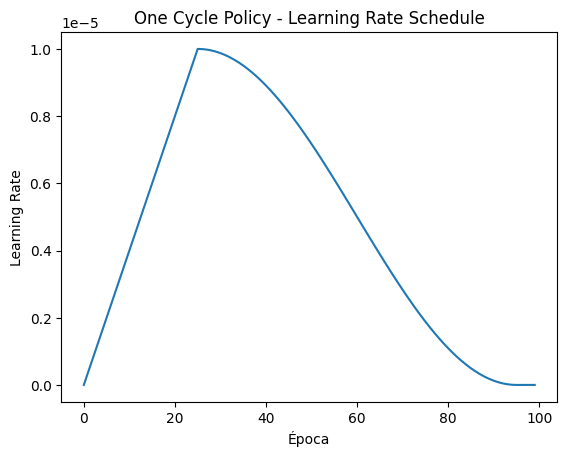

In [46]:
import matplotlib.pyplot as plt  # Corrección en la importación
min_lr = initial_learning_rate
max_lr = min_lr * 1000
lrs = [one_cycle_scheduler(epoch, initial_learning_rate) for epoch in range(epochs)]
plt.plot(range(epochs), lrs)
plt.xlabel("Época")
plt.ylabel("Learning Rate")
plt.title("One Cycle Policy - Learning Rate Schedule")
plt.show()

In [47]:
train_results = model_1.evaluate(train_dataset, verbose=1)

2025-04-16 08:44:30.624740: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 37 of 516
2025-04-16 08:44:40.918291: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 82 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-16 08:44:50.520608: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 119 of 516
2025-04-16 08:45:00.682834: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 148 of 516
2025-04-16 08:45:10.701740: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 178 of 516
2025-04-16 08:45:21.106386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 215 of 516
2025-04-16 08:45:30.977623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 246 of 516
2025-04-16 08:45:40.567336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 278 of 516
2025-04-16 08:45:50.515238: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

      1/Unknown - 151s 151s/step - loss: 0.6911 - accuracy: 0.7500 - auc: 0.7000

2025-04-16 08:46:50.960491: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


65/65 [==============================] - 158s 116ms/step - loss: 0.6925 - accuracy: 0.5465 - auc: 0.5725


In [48]:
# Evaluar en el conjunto de validación
val_results = model_1.evaluate(val_dataset, verbose=1)

9/9 [==============================] - 18s 2s/step - loss: 0.6919 - accuracy: 0.6308 - auc: 0.5549


In [49]:
# Evaluar en el conjunto de prueba
test_results = model_1.evaluate(test_dataset, verbose=1)

9/9 [==============================] - 20s 2s/step - loss: 0.6929 - accuracy: 0.5231 - auc: 0.5436


In [50]:
print("\nResultados Finales:")
print(f"Train - Loss: {train_results[0]}, Accuracy: {train_results[1]}")
print(f"Val - Loss: {val_results[0]}, Accuracy: {val_results[1]}")
print(f"Test - Loss: {test_results[0]}, Accuracy: {test_results[1]}")


Resultados Finales:
Train - Loss: 0.6924762725830078, Accuracy: 0.5465116500854492
Val - Loss: 0.6919060349464417, Accuracy: 0.6307692527770996
Test - Loss: 0.6928930878639221, Accuracy: 0.5230769515037537


### Gráfica Epochs vs Loss

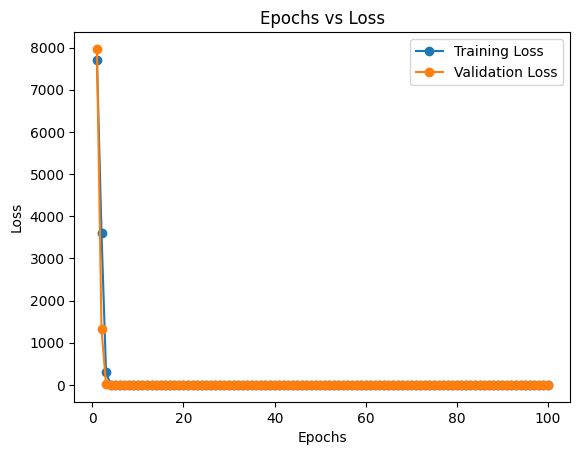

In [51]:
import matplotlib.pyplot as plt
# Extraer la pérdida de entrenamiento y validación
loss = history_full['loss']
val_loss = history_full['val_loss']

# Crear la gráfica
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss', marker='o')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker='o')

# Etiquetas y título
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.legend()
plt.grid(False)
plt.show()

### Visualización del Modelo con TSNE

In [54]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# Obtener las representaciones del modelo
x_test = model_1.predict(test_dataset)  # Extrae los embeddings
y_test = np.concatenate([y for _, y in test_dataset])  # Obtener etiquetas reales

# Verificar el número de muestras
num_samples = x_test.shape[0]
perplexity_value = min(10, num_samples - 1)  # Ajustar perplexity dinámicamente

print(f"Num samples: {num_samples}, Usando perplexity={perplexity_value}")

# Aplicar t-SNE con 2 dimensiones
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
x_test_tsne = tsne.fit_transform(x_test)

# Visualización
plt.figure(figsize=(10, 8))
for i in np.unique(y_test):
    idx = np.where(y_test == i)[0]
    plt.scatter(x_test_tsne[idx, 0], x_test_tsne[idx, 1], label=f"Clase {i}")

plt.title("Visualización t-SNE de los embeddings del conjunto de prueba")
plt.xlabel("Componente t-SNE 1")
plt.ylabel("Componente t-SNE 2")
plt.legend(title="Clases")
plt.grid(True)
plt.show()


Num samples: 65, Usando perplexity=10


ValueError: n_components=2 must be between 1 and min(n_samples, n_features)=1 with svd_solver='randomized'

## I3D + ConvLSTM2D

In [ ]:
from tensorflow.keras.layers import (ConvLSTM2D, TimeDistributed, Dense, 
                                    Flatten, GlobalAveragePooling2D, 
                                    Dropout, BatchNormalization)
from tensorflow.keras import Model

class I3D_ConvLSTM(Model):
    def __init__(self, num_classes, endpoint="Mixed_5c"):
        super(I3D_ConvLSTM, self).__init__()
        np.random.seed(42)
        tf.random.set_seed(42)
        # Modelo base Inception I3D
        self.i3d = InceptionI3d(num_classes=num_classes, is_training=True, final_endpoint=endpoint)
        
        # Capa ConvLSTM2D para modelar información temporal
        self.conv_lstm = ConvLSTM2D(
            filters=64, 
            kernel_size=(3, 3),
            padding='same',
            return_sequences=True,  # Mantener la dimensión temporal
            dropout=0.2,
            recurrent_dropout=0.2
        )
        
        # Batch Normalization después de ConvLSTM
        self.batch_norm = BatchNormalization()
        
        # Global Average Pooling para reducir dimensionalidad
        self.global_avg_pool = GlobalAveragePooling2D()  # Cambio a 2D
        
        # Dropout para regularización
        self.dropout = Dropout(0.3)
        
        # Capa completamente conectada final SIN activación (para logits)
        self.fc = Dense(num_classes)  # Eliminado activation='softmax'

    def call(self, inputs, training=False):
        """Entrada esperada: (batch_size, num_frames, height, width, channels)"""
        
        # Extraer características con I3D
        features, _ = self.i3d(inputs)  # (batch_size, num_frames, 7, 7, 1024)
        
        # Aplicar ConvLSTM2D sobre la dimensión temporal
        lstm_out = self.conv_lstm(features)  # (batch_size, num_frames, 7, 7, 64)
        
        # Tomar solo el último frame de la salida de LSTM para clasificación
        lstm_out = lstm_out[:, -1, :, :, :]  # (batch_size, 7, 7, 64)

        # Batch Normalization
        x = self.batch_norm(lstm_out, training=training)
        
        # Global Average Pooling
        x = self.global_avg_pool(x)
        
        # Dropout para regularización
        x = self.dropout(x, training=training)
        
        # Capa de salida (ahora devuelve logits)
        logits = self.fc(x)
        
        return logits

In [ ]:
# Crear el DataModule
data_module = VideoDataModule(train_df, valid_df, test_df, batch_size=8)
# Obtener los datasets
train_dataset = data_module.train_dataset()
val_dataset = data_module.val_dataset()
test_dataset = data_module.test_dataset()

### Modelo

In [ ]:
epochs = 100  # Número de épocas
initial_learning_rate = 1e-7
num_classes = 2

In [ ]:
model_2 = I3D_ConvLSTM(num_classes=num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_2.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

In [ ]:
# Aplicar LR Finder en entrenamiento corto
lr_finder = LRFinder(start_lr=1e-7, end_lr=10, num_it=100)
for _ in range(5):  # Ejecutar varias veces para obtener mejores resultados
    model_2.fit(train_dataset, epochs=1, steps_per_epoch=100, callbacks=[lr_finder])

2025-04-10 00:07:43.038143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 37 of 516
2025-04-10 00:07:53.371981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 82 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-10 00:08:02.964253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 119 of 516
2025-04-10 00:08:13.105008: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 148 of 516
2025-04-10 00:08:23.095701: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 178 of 516
2025-04-10 00:08:32.910355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 214 of 516
2025-04-10 00:08:43.412599: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 246 of 516
2025-04-10 00:08:52.926216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 278 of 516
2025-04-10 00:09:03.064047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

  1/100 [..............................] - ETA: 4:35:43 - loss: 0.7799 - accuracy: 0.3750

2025-04-10 00:10:03.790609: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


100/100 [==============================] - 182s 149ms/step - loss: 0.8092 - accuracy: 0.5194


2025-04-10 00:10:29.053853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 36 of 516
2025-04-10 00:10:38.902050: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 79 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-10 00:10:48.985697: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 117 of 516
2025-04-10 00:10:58.856156: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 146 of 516
2025-04-10 00:11:08.966897: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 177 of 516
2025-04-10 00:11:19.420271: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 214 of 516
2025-04-10 00:11:29.089872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 244 of 516
2025-04-10 00:11:38.907439: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 275 of 516
2025-04-10 00:11:48.858330: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

100/100 [==============================] - 168s 149ms/step - loss: 0.6607 - accuracy: 0.5814


2025-04-10 00:13:17.421632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 36 of 516
2025-04-10 00:13:27.430209: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 81 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-10 00:13:37.388449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 118 of 516
2025-04-10 00:13:47.354706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 147 of 516
2025-04-10 00:13:57.864547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 178 of 516
2025-04-10 00:14:07.678892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 214 of 516
2025-04-10 00:14:17.612744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 245 of 516
2025-04-10 00:14:27.515384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 277 of 516
2025-04-10 00:14:37.430298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

100/100 [==============================] - 166s 147ms/step - loss: 0.7660 - accuracy: 0.6066


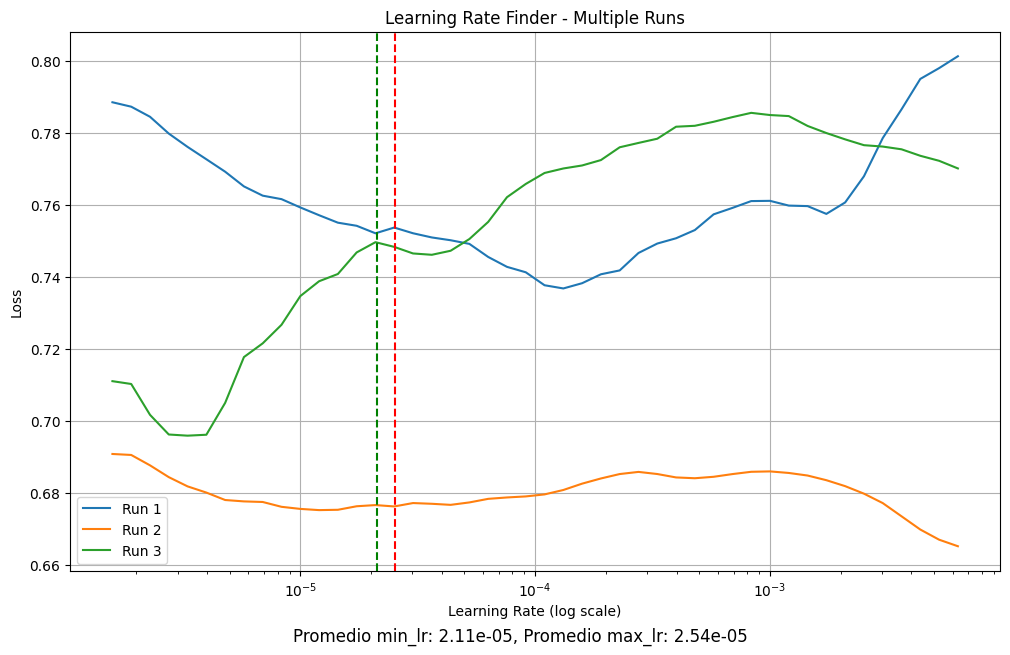

Promedio min_lr: 2.11e-05
Promedio max_lr: 2.54e-05


In [ ]:
# Obtener los valores óptimos de min_lr y max_lr
min_lr, max_lr = lr_finder.plot_all_runs()

In [ ]:
# Ajustar max_lr si es necesario
if abs(max_lr - min_lr) / min_lr < 100:
    max_lr = min_lr * 1000
print(f"min_lr: {min_lr}")
print(f"max_lr: {max_lr}")

999.0
min_lr: 2.1112062444980922e-05
max_lr: 0.02111206244498092


In [ ]:
def one_cycle_scheduler(epoch, lr):
    total_epochs = epochs
    warmup_epochs = total_epochs // 4

    if epoch < warmup_epochs:  # Warmup
        return initial_learning_rate + (max_lr - initial_learning_rate) * (epoch / warmup_epochs)
    
    elif epoch < total_epochs - 5:  # Cosine annealing phase
        return min_lr + (max_lr - min_lr) * 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs - 5)))

    else:  # Final annealing phase
        return min_lr

In [ ]:
history2, history_full2 = train_with_checkpoints(
    model_2,
    train_dataset,
    val_dataset,
    epochs=epochs,
    checkpoint_dir="checkpoints/i3d_convlstm",
    one_cycle_scheduler=one_cycle_scheduler
)

Starting training from scratch.
Epoch 1/2


2025-04-10 00:16:03.936945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 36 of 516
2025-04-10 00:16:13.830521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 80 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-10 00:16:23.717079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 116 of 516
2025-04-10 00:16:33.845223: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 146 of 516
2025-04-10 00:16:44.027830: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 177 of 516
2025-04-10 00:16:53.941140: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 213 of 516
2025-04-10 00:17:03.779672: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 243 of 516
2025-04-10 00:17:13.799831: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 275 of 516
2025-04-10 00:17:23.836297: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 189s 562ms/step - loss: 0.6951 - accuracy: 0.5446 - val_loss: 0.6988 - val_accuracy: 0.4923
Epoch 2/2


2025-04-10 00:19:17.152102: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 37 of 516
2025-04-10 00:19:27.330292: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 82 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-10 00:19:37.620690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 121 of 516
2025-04-10 00:19:47.172707: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 149 of 516
2025-04-10 00:19:57.201047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 179 of 516
2025-04-10 00:20:07.391951: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 215 of 516
2025-04-10 00:20:17.219161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 246 of 516
2025-04-10 00:20:27.185639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 280 of 516
2025-04-10 00:20:37.349930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 184s 516ms/step - loss: 0.6995 - accuracy: 0.5252 - val_loss: 0.6911 - val_accuracy: 0.5077


In [ ]:
train_results = model_2.evaluate(train_dataset, verbose=1)

2025-04-08 00:23:24.822227: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 36 of 516
2025-04-08 00:23:34.738983: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 80 of 516
2025-04-08 00:23:44.768291: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 118 of 516
2025-04-08 00:23:54.758586: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 147 of 516
2025-04-08 00:24:04.735871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 177 of 516
2025-04-08 00:24:15.207309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 214 of 516
2025-04-08 00:24:25.096524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (t

65/65 [==============================] - 161s 121ms/step - loss: 0.5442 - accuracy: 0.7287


In [ ]:
# Evaluar en el conjunto de validación
val_results = model_2.evaluate(val_dataset, verbose=1)

      3/Unknown - 7s 2s/step - loss: 0.3391 - accuracy: 0.9583

9/9 [==============================] - 18s 2s/step - loss: 0.5186 - accuracy: 0.8000


In [ ]:
# Evaluar en el conjunto de prueba
test_results = model_2.evaluate(test_dataset, verbose=1)

9/9 [==============================] - 20s 2s/step - loss: 0.6887 - accuracy: 0.5692


In [ ]:
print("\nResultados Finales:")
print(f"Train - Loss: {train_results[0]}, Accuracy: {train_results[1]}")
print(f"Val - Loss: {val_results[0]}, Accuracy: {val_results[1]}")
print(f"Test - Loss: {test_results[0]}, Accuracy: {test_results[1]}")


Resultados Finales:
Train - Loss: 0.5442267656326294, Accuracy: 0.7286821603775024
Val - Loss: 0.5185882449150085, Accuracy: 0.800000011920929
Test - Loss: 0.6710519194602966, Accuracy: 0.6615384817123413


### Evolución del Learning rate

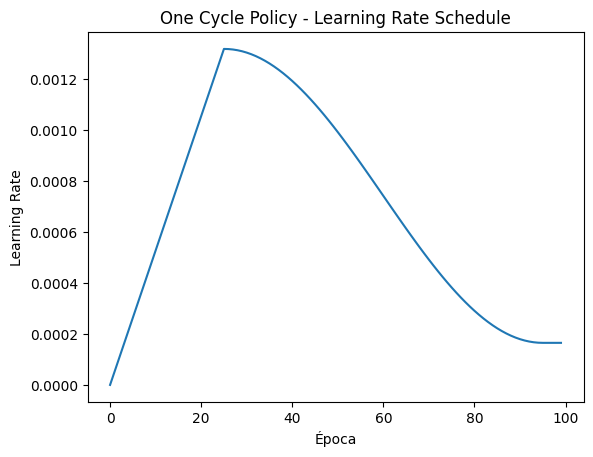

In [ ]:
import matplotlib.pyplot as plt  # Corrección en la importación
lrs = [one_cycle_scheduler(epoch, initial_learning_rate) for epoch in range(epochs)]
plt.plot(range(epochs), lrs)
plt.xlabel("Época")
plt.ylabel("Learning Rate")
plt.title("One Cycle Policy - Learning Rate Schedule")
plt.show()

### Gráfica Epochs vs Loss

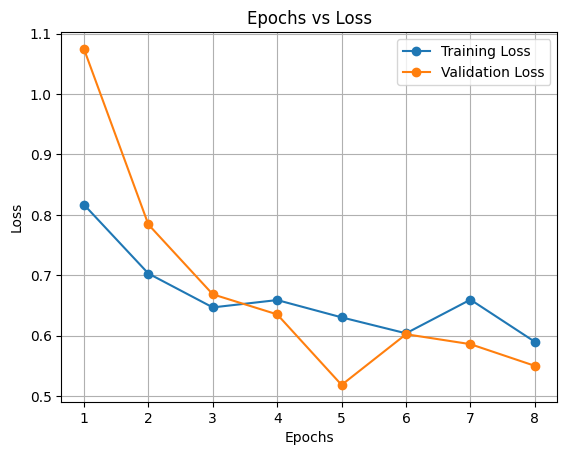

In [ ]:
import matplotlib.pyplot as plt

# Extraer la pérdida de entrenamiento y validación
loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear la gráfica
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss', marker='o')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker='o')

# Etiquetas y título
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.legend()
plt.grid(True)
plt.show()

### Visualización del Modelo con TSNE

Num samples: 65, Usando perplexity=10


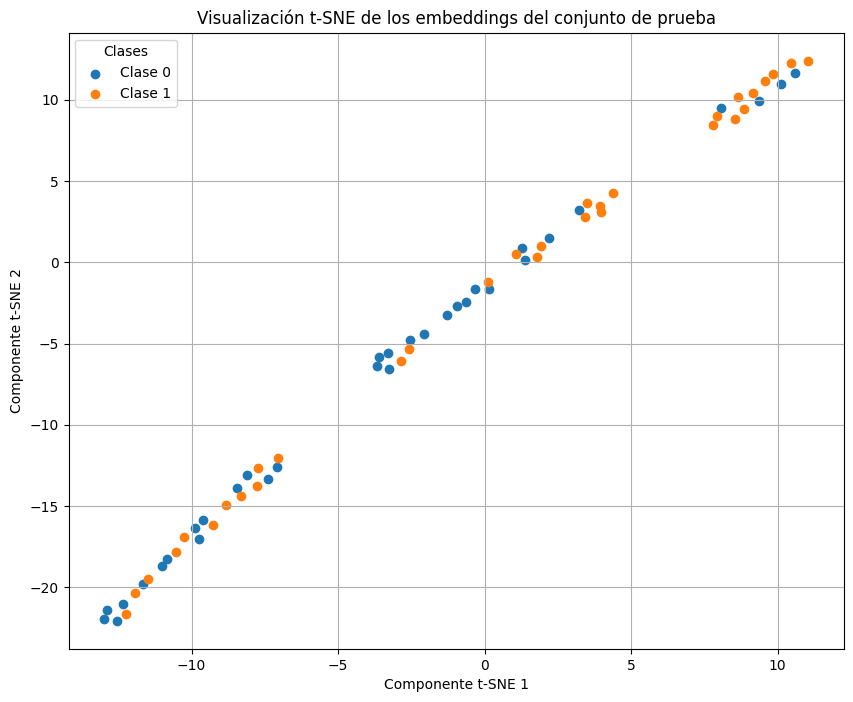

In [ ]:
from sklearn.manifold import TSNE

# Obtener las representaciones del modelo
x_test = model_2.predict(test_dataset)  # Extrae los embeddings
y_test = np.concatenate([y for _, y in test_dataset])  # Obtener etiquetas reales

# Verificar el número de muestras
num_samples = x_test.shape[0]
perplexity_value = min(10, num_samples - 1)  # Ajustar perplexity dinámicamente

print(f"Num samples: {num_samples}, Usando perplexity={perplexity_value}")

# Aplicar t-SNE con un perplexity válido
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
x_test_tsne = tsne.fit_transform(x_test)

# Visualización
plt.figure(figsize=(10, 8))
for i in np.unique(y_test):
    idx = np.where(y_test == i)[0]
    plt.scatter(x_test_tsne[idx, 0], x_test_tsne[idx, 1], label=f"Clase {i}")

plt.title("Visualización t-SNE de los embeddings del conjunto de prueba")
plt.xlabel("Componente t-SNE 1")
plt.ylabel("Componente t-SNE 2")
plt.legend(title="Clases")
plt.grid(True)
plt.show()

## Comparación de modelos

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print('---------------------------------------------')
print("Modelo I3D")
# Obtener predicciones en el conjunto de prueba
y_pred = model_1.predict(test_dataset).argmax(axis=1)

# Obtener etiquetas reales del conjunto de prueba
y_true = np.concatenate([y.numpy() for _, y in test_dataset])  # Convertir a numpy si es un tensor

# Imprimir el reporte de clasificación
print("Classification Report:\n", classification_report(y_true, y_pred))

# Imprimir la matriz de confusión
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

print('---------------------------------------------')
print("Modelo I3D+ConvLSTM")

# Obtener predicciones en el conjunto de prueba
y_pred = model_2.predict(test_dataset).argmax(axis=1)

# Obtener etiquetas reales del conjunto de prueba
y_true = np.concatenate([y.numpy() for _, y in test_dataset])  # Convertir a numpy si es un tensor

# Imprimir el reporte de clasificación
print("Classification Report:\n", classification_report(y_true, y_pred))

# Imprimir la matriz de confusión
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

---------------------------------------------
Modelo I3D
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.45      0.48        33
           1       0.49      0.53      0.51        32

    accuracy                           0.49        65
   macro avg       0.49      0.49      0.49        65
weighted avg       0.49      0.49      0.49        65

Confusion Matrix:
 [[15 18]
 [15 17]]
---------------------------------------------
Modelo I3D+ConvLSTM
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.76      0.69        33
           1       0.69      0.56      0.62        32

    accuracy                           0.66        65
   macro avg       0.67      0.66      0.66        65
weighted avg       0.67      0.66      0.66        65

Confusion Matrix:
 [[25  8]
 [14 18]]
